# review experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import sys
sys.path.insert(1, '/its/home/drs25/Documents/GitHub/Quadruped/Code')
sys.path.insert(1, '/its/home/drs25/Quadruped/Code')
sys.path.insert(1, 'C:/Users/dexte/Documents/GitHub/Quadruped/Code')
from PIL import Image
from environment import *
from CPG import *
from CPG import *
import copy
datapath="/its/home/drs25//Quadruped/"
#datapath="C:/Users/dexte/Documents/GitHub/Quadruped/"
np.set_printoptions(suppress=True, precision=4)

pybullet build time: Jan 21 2025 13:32:20


In [35]:
def plot_trials(trials,labels=[],colours=[],max_=-1,title="",keys=[],cmap=plt.cm.inferno,grid=15,n=3):
    #trials should be in the num trial, data
    try: #make sure that it is in a bigger array
        l=len(trials[0])
    except:
        trials=[trials]
        labels=[labels]
        colours=[colours]
    fig, ax = plt.subplots()
    background=np.zeros((grid,grid,3), dtype=np.uint8)+255
    colour=(180, 202, 237)
    size=len(background)
    for i in range(0, size, n):
        for j in range(0, size, n):
            if (i // n + j // n) % 2 == 0:
                background[i:i+n, j:j+n] = colour
    ax.imshow(background)
    for sample in range(len(trials)):
        for i, trial in enumerate(trials[sample]):
            trial=trial+15//2
            a=trial[:max_,0]
            b=trial[:max_,1]
            c=colours[sample][i]
            d=labels[sample][i]
            ax.plot(trial[:max_,0],trial[:max_,1],c=colours[sample][i],label=labels[sample][i])
        plt.title(title)
    if len(trials[sample])>6 and type(labels[sample][0])!=type("string"): #too many trials to show
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(keys), vmax=max(keys)))
            sm.set_array([])  # Required to avoid errors

            # Add colorbar to the correct axis
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label(labels[0].split(" ")[0])
    elif len(trials[sample])>6: #still too many trials but it is a string
        handles, labels = ax.get_legend_handles_labels()
        unique = dict(zip(labels, handles))  # Keeps last occurrence

        plt.legend(unique.values(), unique.keys())
    else:
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax.set_xlabel("X simulation position",fontsize=14)
    ax.set_ylabel("Y simulation position",fontsize=14)
    plt.tight_layout()
    plt.savefig(datapath+"/assets/biped_"+str(title.replace(" ","_")+".pdf"))
    plt.show()
def get_colormap_shades(colormap_name, num_samples):
    cmap = plt.get_cmap(colormap_name)
    indices = np.arange(0,1,1/num_samples)
    shades = [cmap(i) for i in indices]
    return shades

def get_Data_ga(param,sample=20,folder=""):
   dt=0.1
   best_CPGs=[]
   fitnesses=[]
   MAX=sample
   pop=[]
   hist=[]
   for i in range(0,MAX):
      filename=datapath+'/models'+folder+'/genotypes_dt'+str(dt)+"_"+str(param)+"_"+str(i)+"_friction"+str(0.5)
      population=None
      f_=np.load((filename+'.npy').replace("genotypes","fitnesses"))
      history=np.load((filename+'.npy').replace("genotypes","history"))#
      if len(history.shape)<300:
         history=np.concatenate([history,np.array([0]*(300-len(history)))])
      hist.append(history)
      best_geno=np.argmax(f_)
      fitnesses.append(np.max(f_))
      best_CPGs.append(pop)
      try:
         with open(filename+'.pkl', 'rb') as f:
            population = pickle.load(f)
         pop.append(population[best_geno])
      except EOFError:
         print("error loading... corruption")
         pop.append(None)
   fitnesses=np.array(fitnesses).reshape((MAX))
   history=np.array(hist)
   return fitnesses,history,best_CPGs

def get_paths(fitnesses,best_CPGs,name=""):
    friction_data=[]
    env=environment(0)
    c=0
    frictions=[]
    labels=[]
    t=time.time()
    for i in range(len(best_CPGs)):
        best_of_trial=np.argmax(fitnesses[i])
        best=best_CPGs[i][best_of_trial]
        fit,hist,photos=env.runTrial(best,100,delay=0,fitness=F3)
        friction_data.append(copy.deepcopy(hist))
        frictions.append(hist['positions'])
        labels.append(name)
    env.stop()
    print("done in",(time.time()-t)/60,"minutes")
    return frictions,labels

def F1(robot,history={}): 
    fitness=0
    #look at behaviour over time
    if len(history.get('motors',[]))>0:
        distances=np.array(history['positions'])-np.array([robot.start])#euclidean_distance(np.array(history['positions']),np.array([robot.start]))
        distancesX=distances[-1][0]
        distancesY=distances[-1][1]
        distancesZ=distances[-1][2]
        fitness+=distancesX - (distancesY+distancesZ)/10 #np.sum(distances)
    if robot.hasFallen(): fitness=-1000
    if type(fitness)!=type(0): 
        try:
            if type(fitness)==type([]): fitness=float(fitness[0])
            else:fitness=float(fitness)
        except:
            print("shit",fitness,np.array(history['motors']).shape,np.array(history['positions']).shape,np.array(history['orientations']).shape)
            fitness=-1000
    return fitness

def F2(robot,history={}): 
    fitness=0
    #look at behaviour over time
    if len(history.get('motors',[]))>0:
        alpha=10
        beta=0.05
        gamma=0.5
        positions = np.array(history['positions'])  # Shape (T, 3)
        X, Y, Z = positions[:, 0], positions[:, 1], positions[:, 2]
        forward_movement = np.abs(X[-1] - X[0])
        deviation_penalty = np.sum(np.sqrt(Y**2 + Z**2))
        velocities = np.diff(positions, axis=0)
        smoothness_penalty = np.sum(np.linalg.norm(np.diff(velocities, axis=0), axis=1))
        #print(forward_movement, deviation_penalty, smoothness_penalty)
        fitness = (alpha * forward_movement) - (beta * deviation_penalty) - (gamma * smoothness_penalty)
    if robot.hasFallen(): fitness=-1000
    if type(fitness)!=type(0): 
        try:
            if type(fitness)==type([]): fitness=float(fitness[0])
            else:fitness=float(fitness)
        except:
            print("shit",fitness,np.array(history['motors']).shape,np.array(history['positions']).shape,np.array(history['orientations']).shape)
            fitness=-1000
    return fitness

def F3(robot,history={}): 
    fitness=0
    #look at behaviour over time
    if len(history.get('motors',[]))>0:
        positions = np.array(history['positions'])
        Y, X, Z = positions[:, 0], positions[:, 1], positions[:, 2]
        orientations=history['orientations']
        magnitude=np.sqrt(np.sum(np.square(orientations),axis=1))
        forward_movement = np.abs(X[-1] - X[0])
        fitness=np.abs(np.sum(np.diff(Y))) - np.sum(np.abs(magnitude))/10
    if robot.hasFallen(): fitness=-1000
    if type(fitness)!=type(0): 
        try:
            if type(fitness)==type([]): fitness=float(fitness[0])
            else:fitness=float(fitness)
        except:
            print("shit",fitness,np.array(history['motors']).shape,np.array(history['positions']).shape,np.array(history['orientations']).shape)
            fitness=-1000
    return fitness

## load in data

### dt

In [4]:
best_CPGs=[]
fitnesses=[]
trials=2
for _ in range(1,trials+1):
    for dt in np.arange(0.05,1.5,0.05):
        filename = datapath+'/models/genotypes_dt'+str(dt)+"_"+str(_)
        population=None
        with open(filename+'.pkl', 'rb') as f:
            population = pickle.load(f)
        f_=np.load((filename+'.npy').replace("genotypes","fitnesses"))
        best_geno=np.argmax(f_)
        best_CPGs=population[best_geno]
        fitnesses.append(np.max(f_))

fitnesses=np.array(fitnesses).reshape(len(np.arange(0.05,1.5,0.05)),trials).T
print(fitnesses.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/its/home/drs25//Quadruped//models/genotypes_dt0.05_1.pkl'

#### average dt

ValueError: x and y must have same first dimension, but have shapes (29,) and (1,)

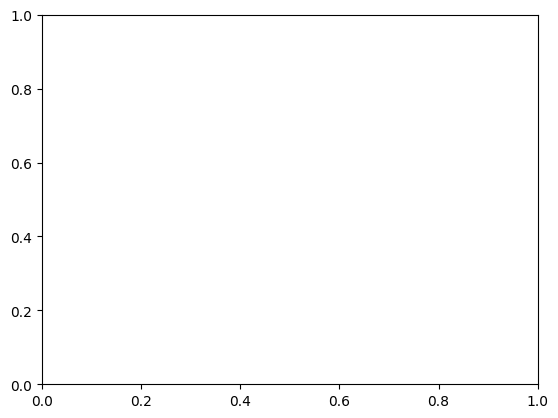

In [ ]:
size=len(np.arange(0.05,1.5,0.05))
plt.plot(np.arange(0.05,1.5,0.05),np.average(fitnesses,axis=0),label="Average")
plt.plot(np.arange(0.05,1.5,0.05),np.min(fitnesses,axis=0),label="Minimum")
plt.plot(np.arange(0.05,1.5,0.05),np.max(fitnesses,axis=0),label="Maximum")
plt.xlabel("dt")
plt.ylabel("Fitness Units")
plt.title("Average fitness in relation to dt value")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### trials

(39,) [-2.1283 -3.0801 -3.5432 -2.4723 -1.1611 -2.2847 -3.5722 -2.9848 -3.3419
 -2.7006 -3.8609 -3.947  -4.1217 -4.7195 -3.4687 -2.1483 -3.1602 -3.3458
 -4.1443 -4.2251 -2.1197 -4.884  -2.7292 -2.5228 -2.9068 -3.7141 -2.2937
 -2.3447 -3.73   -4.8674 -2.9951 -2.0562 -3.7059 -2.4035 -1.685  -3.0969
 -2.5166 -3.6886 -3.1129] (39, 290)


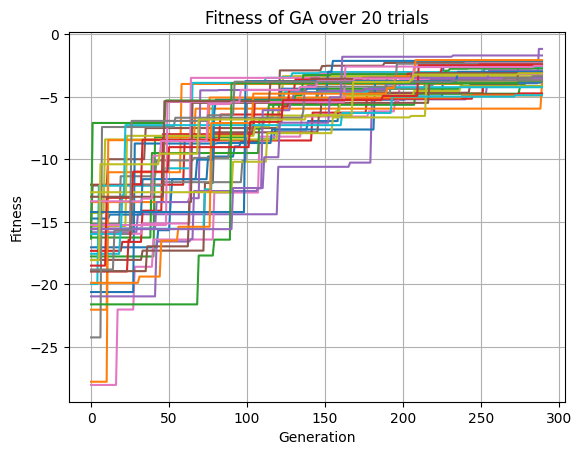

In [5]:
def load_data(fitness="F1"):
    best_CPGs=[]
    fitnesses=[]
    history=[]
    trials=40
    dt=0.1
    for _ in range(1,trials):
        filename = datapath+'/models/genotypes_dt'+str(dt)+"_6_neurons_"+str(_)+"_"+fitness
        population=None
        with open(filename+'.pkl', 'rb') as f:
            population = pickle.load(f)
        f_=np.load((filename+'.npy').replace("genotypes","fitnesses"))
        history.append(np.load((filename+'.npy').replace("genotypes","history")))
        best_geno=np.argmax(f_)
        best_CPGs.append(population[best_geno])
        fitnesses.append(np.max(f_))

    fitnesses=np.array(fitnesses).reshape(trials-1)
    history=np.array(history)[:,:-10]
    return fitnesses,history,best_CPGs

fitnesses,history,best_CPGs=load_data(fitness="F1")
print(fitnesses.shape,fitnesses,history.shape)
plt.plot(history.T)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness of GA over 20 trials")
plt.grid(True)
plt.show()

#### average trials

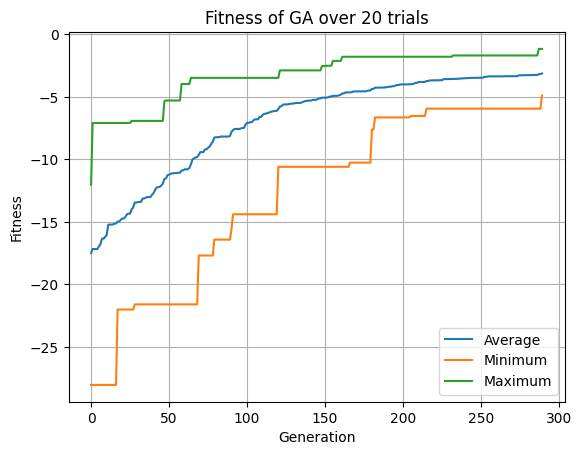

In [6]:

plt.plot(np.average(history,axis=0),label="Average")
plt.plot(np.min(history,axis=0),label="Minimum")
plt.plot(np.max(history,axis=0),label="Maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness of GA over 20 trials")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Genetic algorithm type

In [11]:


mic_fit,mic_hist,mic_cpg=get_Data_ga("Microbial")
dif_fit,dif_hist,dif_cpg=get_Data_ga("Differential")
hil_fit,hil_hist,hil_cpg=get_Data_ga("Hillclimber")

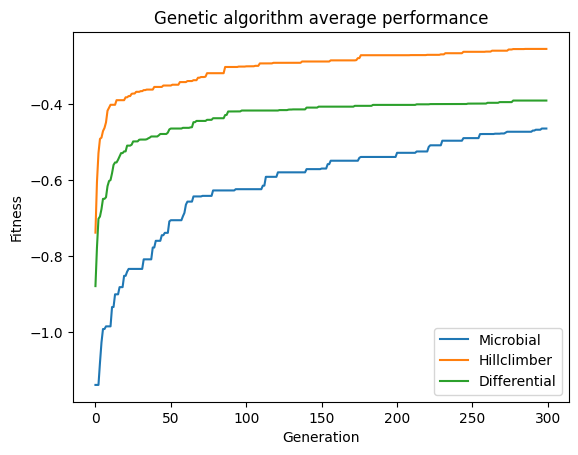

In [7]:
"""for i in range(len(mic_hist)):
    plt.plot(mic_hist[i])
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Genetic algorithm training")
plt.show()"""

plt.plot(np.average(mic_hist,axis=0),label="Microbial")
plt.plot(np.average(hil_hist,axis=0),label="Hillclimber")
plt.plot(np.average(dif_hist,axis=0)[1:],label="Differential")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Genetic algorithm average performance")
plt.legend(loc="lower right")
plt.show()

### view

In [34]:
paths_hil,labels_hill=get_paths(hil_fit,hil_cpg,"Hillclimber")
paths_dif,labels_diff=get_paths(dif_fit,dif_cpg,"Differential")
paths_mic,labels_mic=get_paths(mic_fit,mic_cpg,"Microbial")

done in 2.768651060263316 minutes
done in 2.7838640093803404 minutes
done in 2.724427298704783 minutes


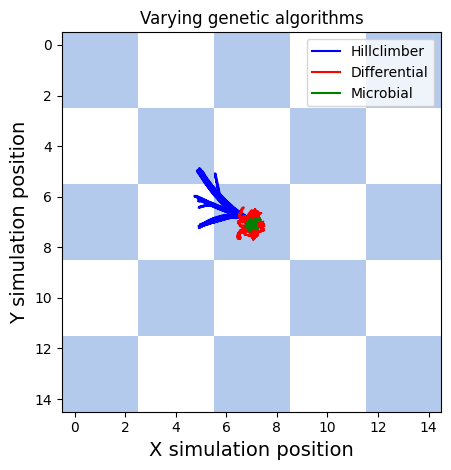

In [35]:
c=[["b" for i in range(len(paths_hil))],["r" for i in range(len(paths_dif))],["g" for i in range(len(paths_mic))]]
plot_trials([paths_hil,paths_dif,paths_mic],labels=[labels_hill,labels_diff,labels_mic],colours=c,max_=-1,title="Varying genetic algorithms",keys=np.arange(0,1.5,0.05),cmap=plt.cm.inferno)


## Sine wave

done in 0.750740400950114 minutes


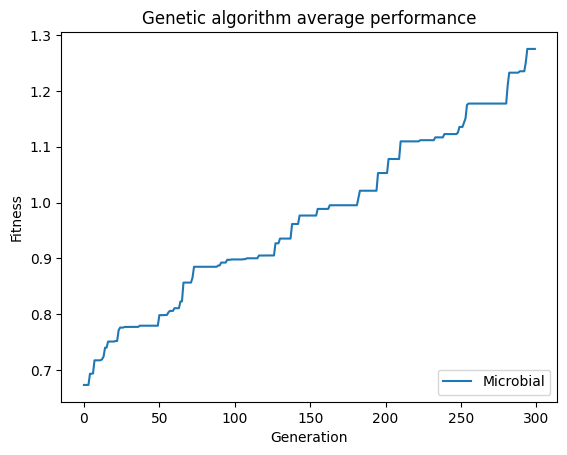

(20, 300)


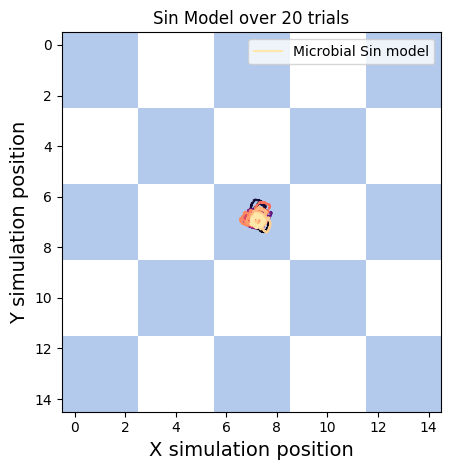

In [41]:
sin_fit,sin_hist,sin_cpg=get_Data_ga("SinBotMicrobial",sample=20,folder="/SinBotMicrobial/")
paths_sin,labels_sin=get_paths(sin_fit,sin_cpg,"Microbial Sin model")

plt.plot(np.average(sin_hist,axis=0),label="Microbial")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Genetic algorithm average performance")
plt.legend(loc="lower right")
plt.show()

shades = [get_colormap_shades("magma", len(np.arange(0,20)))]
print(sin_hist.shape)
plot_trials([paths_sin],labels=[labels_sin],colours=shades,max_=-1,title="Sin Model over 20 trials",keys=np.arange(0,20),cmap=plt.cm.inferno)

done in 0.1679422974586487 minutes


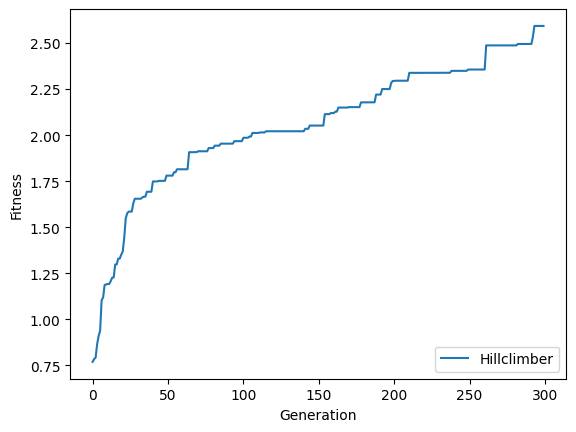

(10, 300)


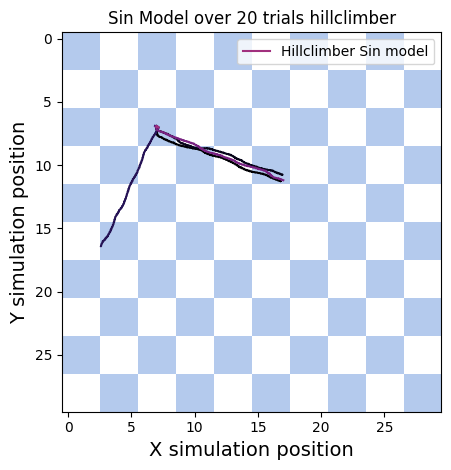

In [50]:
sin_fit,sin_hist,sin_cpg=get_Data_ga("SinBotHillclimber",sample=10,folder="/SinBotHillclimber/")
paths_sin,labels_sin=get_paths(sin_fit,sin_cpg,"Hillclimber Sin model")

plt.plot(np.average(sin_hist,axis=0),label="Hillclimber")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

shades = [get_colormap_shades("magma", len(np.arange(0,20)))]
print(sin_hist.shape)
plot_trials([paths_sin],labels=[labels_sin],colours=shades,max_=-1,title="Sin Model over 20 trials hillclimber",keys=np.arange(0,20),cmap=plt.cm.inferno,grid=30,n=3)

## fitness functions

In [86]:
fitnesses1,history1,best_CPGs1=load_data(fitness="F1")
fitnesses2,history2,best_CPGs2=load_data(fitness="F2")
fitnesses3,history3,best_CPGs3=load_data(fitness="F3")

In [87]:
from environment import *
from CPG import *
F1_data=[]
F2_data=[]
F3_data=[]
env=environment(0)
for i in range(len(best_CPGs1)):
    fit,hist,photos=env.runTrial(best_CPGs1[i],300,delay=0,fitness=F1)
    F1_data.append(hist)
    fit,hist,photos=env.runTrial(best_CPGs2[i],300,delay=0,fitness=F2)
    F2_data.append(hist)
    fit,hist,photos=env.runTrial(best_CPGs3[i],300,delay=0,fitness=F3)
    F3_data.append(hist)
env.stop()

### fitnesses

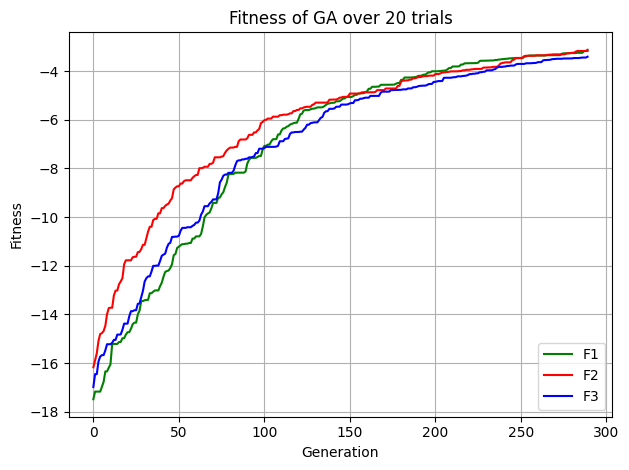

In [10]:
plt.plot(np.average(history1,axis=0),c="g",label="F1")
#plt.plot(np.min(history,axis=0),"--",c="g",label="Minimum")
#plt.plot(np.max(history,axis=0),".",c="g",label="Maximum")
plt.plot(np.average(history2,axis=0),c="r",label="F2")
plt.plot(np.average(history3,axis=0),c="b",label="F3")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness of GA over 20 trials")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(datapath+"/assets/fitness.pdf")
plt.show()

### position

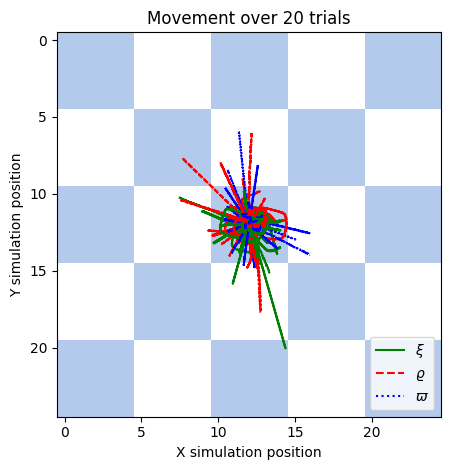

In [89]:
background=np.zeros((25,25,3), dtype=np.uint8)+255
n=5
colour=(180, 202, 237)
size=len(background)
for i in range(0, size, n):
    for j in range(0, size, n):
        if (i // n + j // n) % 2 == 0:
            background[i:i+n, j:j+n] = colour
plt.imshow(background)
max_=len(F1_data[0]['positions'])
for i in range(len(F1_data)):
    positions1=F1_data[i]['positions']+25//2
    positions2=F2_data[i]['positions']+25//2
    positions3=F3_data[i]['positions']+25//2
    plt.plot(positions1[:max_,0],positions1[:max_,1],c="g")
    plt.plot(positions2[:max_,0],positions2[:max_,1],"--",c="r")
    plt.plot(positions3[:max_,0],positions3[:max_,1],":",c="b")
plt.plot(positions1[:max_,0],positions1[:max_,1],c="g",label=r"$\xi$")
plt.plot(positions2[:max_,0],positions2[:max_,1],"--",c="r",label=r"$\varrho$")
plt.plot(positions3[:max_,0],positions3[:max_,1],":",c="b",label=r"$\varpi$")

plt.title("Movement over 20 trials")
plt.legend(loc="lower right")
plt.xlabel("X simulation position")
plt.ylabel("Y simulation position")
plt.tight_layout()
plt.savefig(datapath+"/assets/fitness_gaits.pdf")
plt.show()

### speed

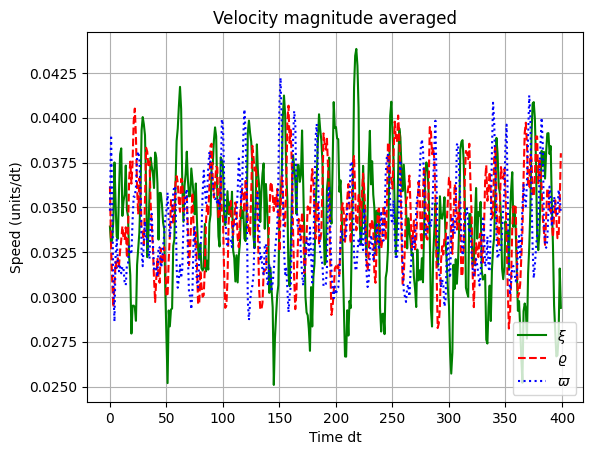

In [103]:
def compute_average_velocity(positions, delta_t=0.1):
    velocities = np.diff(positions, axis=1) / delta_t  
    speeds = np.linalg.norm(velocities, axis=2)
    avg_speed = np.mean(speeds, axis=0) 
    return avg_speed
positions1=[]
positions2=[]
positions3=[]
for i in range(len(F1_data)):
    positions1.append(F1_data[i]['positions'])
    positions2.append(F2_data[i]['positions'])
    positions3.append(F3_data[i]['positions'])
positions1=np.array(positions1)
positions2=np.array(positions2)
positions3=np.array(positions3)
speed1=compute_average_velocity(positions1)
speed2=compute_average_velocity(positions2)
speed3=compute_average_velocity(positions3)
show=400
plt.plot(speed1[0:show],c="g",label=r"$\xi$")
plt.plot(speed2[0:show],"--",c="r",label=r"$\varrho$")
plt.plot(speed3[0:show],":",c="b",label=r"$\varpi$")
plt.legend(loc="lower right")
plt.title("Velocity magnitude averaged")
plt.ylabel("Speed (units/dt)")
plt.xlabel("Time dt")
plt.grid(1)
plt.show()

## Display images

(5, 480, 640, 4)


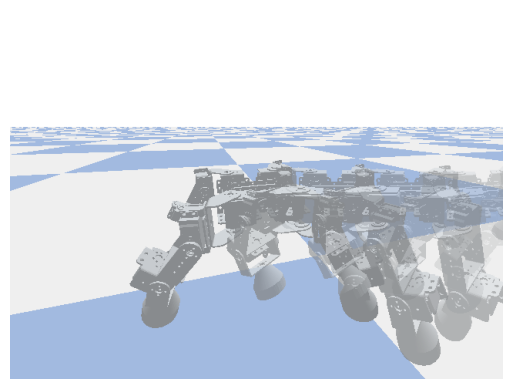

In [ ]:

#write function that removes everything but robot
def remove_back(image,alpha=0):
    remove_colors = [(255, 255, 255), (162, 186, 224), (239, 239, 239)]
    image_pix = image[:, :, :3]  # Extract RGB channels
    # Ensure the image has an alpha channel
    if image.shape[2] == 3:
        image = np.dstack((image, np.full(image.shape[:2], 255, dtype=np.uint8)))  # Add alpha channel
    for color in remove_colors:
        mask = np.all(image_pix == color, axis=-1)
        image[mask]=0
        image[mask, 3] = alpha  # Set alpha to 0 (fully transparent) for matching colors
    return image
def change_robot_vis(image,alpha=0):
    image_pix = image[:, :, :3]  # Extract RGB channels
    # Ensure the image has an alpha channel
    if image.shape[2] == 3:
        image = np.dstack((image, np.full(image.shape[:2], 255, dtype=np.uint8)))  # Add alpha channel
    mask = np.all(image_pix != (0,0,0), axis=-1)
    image[mask, 3] = alpha  # Set alpha to 0 (fully transparent) for matching colors
    return image

def overlay_images_shifted(images, shift=100):
    base = images[0].astype(np.float32)
    h, w = base.shape[:2]

    for i, overlay in enumerate(images[1:], start=1):
        overlay = change_robot_vis(remove_back(overlay,0),(len(images)-i)/len(images) *255)
        #overlay[:,:,3]=0#(len(images)-i)/len(images) *100
        overlay = overlay.astype(np.float32)
        overlay = cv2.resize(overlay, (w, h), interpolation=cv2.INTER_LANCZOS4) if overlay.shape[:2] != (h, w) else overlay
        shift_x = min(i * shift, w)  # Ensure shifting doesn't exceed width
        shifted_overlay = np.zeros_like(base)

        if overlay.shape[-1] == 4:
            shifted_overlay[:, shift_x:] = overlay[:, :w - shift_x]  # Shift right
        else:
            shifted_overlay[:, shift_x:, :3] = overlay[:, :w - shift_x, :3]  # Shift RGB
            shifted_overlay[:, shift_x:, 3:4] = 255  # Full alpha

        alpha_overlay = shifted_overlay[..., 3:4] / 255.0
        alpha_base = base[..., 3:4] / 255.0
        blended_rgb = shifted_overlay[..., :3] * alpha_overlay + base[..., :3] * (1 - alpha_overlay)
        blended_alpha = alpha_overlay + alpha_base * (1 - alpha_overlay)
        base = np.concatenate([blended_rgb, blended_alpha * 255], axis=-1)

    return base.astype(np.uint8)

images=np.load(datapath+"/assets/frames.npy")[0:5]
print(images.shape)
image=overlay_images_shifted(images)
output_image = Image.fromarray(image)
output_image.save(datapath+"/assets/robot.png", format="PNG")
plt.imshow(image)
plt.axis("off")
plt.show()



## friction

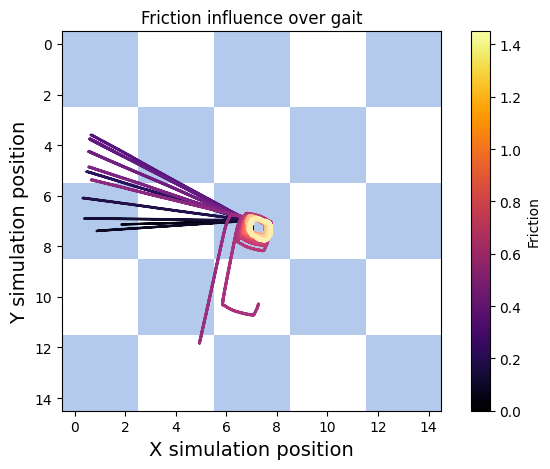

In [90]:


best_CPG=best_CPGs1[np.argmax(fitnesses2)]
frictions=[]
labels=[]
for i,val in enumerate(np.arange(0,1.5,0.05)):
    env=environment(0,friction=val)
    fit,hist,photos=env.runTrial(best_CPG,600,delay=0,fitness=F2)
    env.close()
    del env
    frictions.append(hist['positions'].copy())
    labels.append("Friction = "+str(round(val,2)))

shades = get_colormap_shades("magma", len(np.arange(0,1.5,0.05)))
plot_trials([frictions],labels=[labels],colours=shades,max_=-1,title="Friction influence over gait",keys=np.arange(0,1.5,0.05))

## train RNN on trajectories

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
#extract vectors from code and add to input
X=[]
y=[]
for i in range(len(F1_data)):
    positions1=F1_data[i]['positions']
    vector = positions1[-1]-positions1[0]
    motors1=np.radians(F1_data[i]['motors'])
    X.append(np.concatenate([motors1, np.tile(vector, (motors1.shape[0], 1))], axis=1))  # Append vector

    positions1=F2_data[i]['positions']
    vector = positions1[-1]-positions1[0]
    motors1=np.radians(F2_data[i]['motors'])
    X.append(np.concatenate([motors1, np.tile(vector, (motors1.shape[0], 1))], axis=1))  # Append vector

    positions1=F3_data[i]['positions']
    vector = positions1[-1]-positions1[0]
    motors1=np.radians(F3_data[i]['motors'])
    X.append(np.concatenate([motors1, np.tile(vector, (motors1.shape[0], 1))], axis=1))  # Append vector

X=np.array(X)
#create RNN class
print(X.shape)

(117, 1000, 15)


In [ ]:
np.save(datapath+"/models/motor_positions",X)


### lstm

In [ ]:
#train RNN to predict correct patterns
class MotorPredictionLSTM(nn.Module):
    def __init__(self, input_dim=15, hidden_dim=50, output_dim=12, num_layers=2):
        super(MotorPredictionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        #self.fc = nn.Linear(hidden_dim, output_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Adjust activation if needed
        )
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out)  # Predict next motor positions for each time step
        return output
    

model = MotorPredictionLSTM().to(device)
criterion = nn.MSELoss()  # Since this is a regression task
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, data_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in data_loader:  # Assumes DataLoader yields (X, Y)
            inputs, targets = inputs.float(), targets.float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        if epoch%100==0:
            print(f"Epoch {epoch+1}, Loss: {loss.item()}")

X_data=X[:,0:60,:].copy()
Y_data=X[:,0:60,0:12].copy()
Y_data = np.roll(Y_data, shift=-1, axis=1)  
Y_data[:, -1, :] = Y_data[:, -2, :]  
X_train = torch.tensor(X_data, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_data, dtype=torch.float32).to(device)
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

train_model(model, train_loader,20000)

Epoch 1, Loss: 3.309441328048706
Epoch 101, Loss: 1.5560508966445923
Epoch 201, Loss: 1.5541789531707764
Epoch 301, Loss: 1.5611011981964111
Epoch 401, Loss: 1.5582404136657715
Epoch 501, Loss: 1.5540673732757568
Epoch 601, Loss: 1.5410370826721191
Epoch 701, Loss: 1.556065320968628
Epoch 801, Loss: 1.5562223196029663
Epoch 901, Loss: 1.5491883754730225
Epoch 1001, Loss: 1.5438910722732544
Epoch 1101, Loss: 1.5397425889968872
Epoch 1201, Loss: 1.557423710823059
Epoch 1301, Loss: 1.5388174057006836
Epoch 1401, Loss: 1.536087989807129
Epoch 1501, Loss: 1.5459766387939453
Epoch 1601, Loss: 1.5523016452789307
Epoch 1701, Loss: 1.527538776397705
Epoch 1801, Loss: 1.5523513555526733
Epoch 1901, Loss: 1.5490188598632812
Epoch 2001, Loss: 1.5484029054641724
Epoch 2101, Loss: 1.5502029657363892
Epoch 2201, Loss: 1.5608469247817993
Epoch 2301, Loss: 1.540166974067688
Epoch 2401, Loss: 1.537384033203125
Epoch 2501, Loss: 1.5460948944091797
Epoch 2601, Loss: 1.547417163848877
Epoch 2701, Loss: 1.5

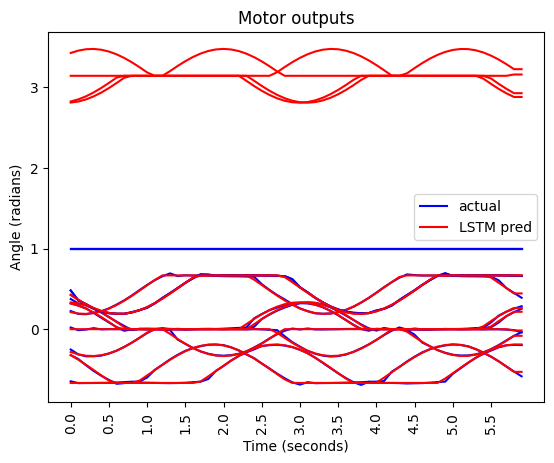

In [ ]:

outputs=model(X_train[0:10,0:60,:])
plt.plot(outputs[0].cpu().detach().numpy().tolist(),"b")
plt.plot(Y_train[0,0:60,0:12].cpu().detach().numpy().tolist(),"r")
plt.plot(outputs[0][0:60,0].cpu().detach().numpy().tolist(),"b",label="actual")
plt.plot(Y_train[0,0:60,0].cpu().detach().numpy().tolist(),"r",label="LSTM pred")
plt.legend(loc="center right")
plt.title("Motor outputs")
plt.ylabel("Angle (radians)")
plt.xlabel("Time (seconds)")
plt.xticks([i for i in range(0,60,5)],[round(i*0.1,1) for i in range(0,60,5)],rotation=90)
plt.show()

(101, 15)


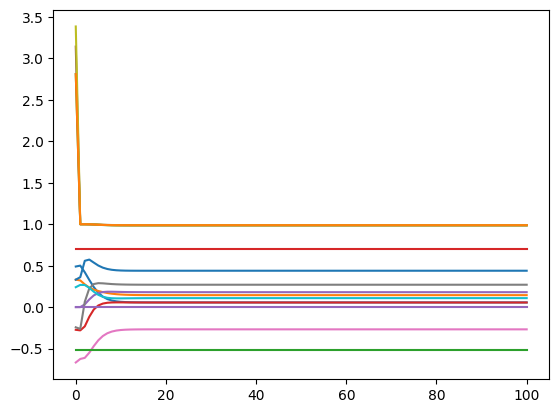

In [ ]:
test=X_train[0:1,0:1,:]
gathered=[test]
for i in range(100):
    inp=torch.concatenate([gathered[i] for i in range(len(gathered))])
    out=model(inp)
    vectors=gathered[-1][:,0:1,12:15]
    gathered.append(torch.concat([out[-1:,:,:],vectors],axis=2))
for i in range(101):
    gathered[i]=gathered[i].cpu().detach().numpy()
gathered=np.array(gathered).reshape(101,15)
print(gathered.shape)
plt.plot(gathered)
plt.show()

### transformer

In [ ]:
class MotorPredictionTransformer(nn.Module):
    def __init__(self, input_dim=15, output_dim=12, seq_len=100, d_model=64, num_heads=4, num_layers=2, dropout=0.3):
        super(MotorPredictionTransformer, self).__init__()

        self.input_embedding = nn.Linear(input_dim, d_model)  # Project input to d_model dimension
        self.positional_encoding = self.create_positional_encoding(seq_len, d_model)
        
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.fc_out = nn.Sequential(
            nn.Linear(d_model, output_dim),
            nn.Tanh()  # Helps smooth noisy predictions
        )
    def create_positional_encoding(self, seq_len, d_model):
        """ Create a positional encoding tensor for the transformer. """
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # Shape (1, seq_len, d_model)

    def forward(self, x):
        # Add positional encoding
        x = self.input_embedding(x) + self.positional_encoding.to(x.device)  # Shape: (batch, seq_len, d_model)
        x = self.transformer_encoder(x)  # Shape: (batch, seq_len, d_model)
        output = self.fc_out(x)  # Shape: (batch, seq_len, output_dim)
        return output

In [ ]:
def train_transformer(model, X_train, Y_train, epochs=10, batch_size=8):
    model.train()
    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(data_loader):.6f}")


X_data=X[:,0:100,:].copy()
Y_data=X[:,1:101,0:12].copy()
#Y_data = np.roll(Y_data, shift=-1, axis=1)  
#Y_data[:, -1, :] = Y_data[:, -2, :]  
X_train = torch.tensor(X_data, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_data, dtype=torch.float32).to(device)   

modelT = MotorPredictionTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(modelT.parameters(), lr=0.0001)
train_transformer(modelT, X_train, Y_train, epochs=1000, batch_size=16)

Epoch 1, Loss: 3.629537
Epoch 2, Loss: 3.518462
Epoch 3, Loss: 3.397376
Epoch 4, Loss: 3.281574
Epoch 5, Loss: 3.170826
Epoch 6, Loss: 3.051774
Epoch 7, Loss: 2.945922
Epoch 8, Loss: 2.847911
Epoch 9, Loss: 2.749710
Epoch 10, Loss: 2.664979
Epoch 11, Loss: 2.584259
Epoch 12, Loss: 2.511908
Epoch 13, Loss: 2.447899
Epoch 14, Loss: 2.390231
Epoch 15, Loss: 2.339915
Epoch 16, Loss: 2.290281
Epoch 17, Loss: 2.254085
Epoch 18, Loss: 2.212449
Epoch 19, Loss: 2.181651
Epoch 20, Loss: 2.148730
Epoch 21, Loss: 2.123263
Epoch 22, Loss: 2.099491
Epoch 23, Loss: 2.078342
Epoch 24, Loss: 2.055655
Epoch 25, Loss: 2.036249
Epoch 26, Loss: 2.020841
Epoch 27, Loss: 2.005100
Epoch 28, Loss: 1.992246
Epoch 29, Loss: 1.981206
Epoch 30, Loss: 1.965222
Epoch 31, Loss: 1.953865
Epoch 32, Loss: 1.945259
Epoch 33, Loss: 1.935131
Epoch 34, Loss: 1.925804
Epoch 35, Loss: 1.916611
Epoch 36, Loss: 1.909240
Epoch 37, Loss: 1.902532
Epoch 38, Loss: 1.893680
Epoch 39, Loss: 1.885566
Epoch 40, Loss: 1.880281
Epoch 41,

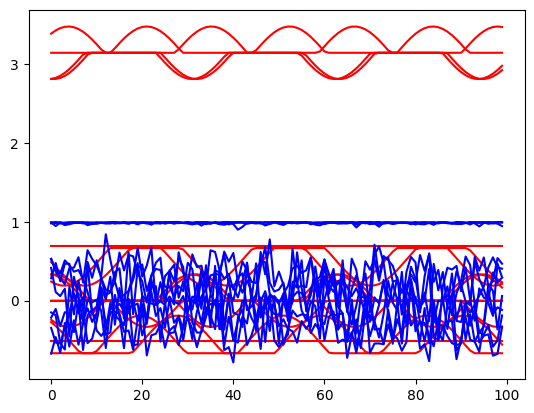

In [ ]:
test=X_train[0:1,0:100,:]
pred=modelT(test).cpu().detach().numpy()

plt.plot(test[0].cpu().detach().numpy(),"r")
plt.plot(pred[0],"b")
plt.show()

In [ ]:
"""
gathered=[test]
for i in range(100):
    inp=torch.concatenate([gathered[i] for i in range(len(gathered))])
    out=model(inp)
    vectors=gathered[-1][:,:,12:15]
    gathered.append(torch.concat([out[-1:,i:i+1,:],vectors],axis=2))
for i in range(101):
    gathered[i]=gathered[i].cpu().detach().numpy()
gathered=np.array(gathered).reshape(101,15)
print(gathered.shape)
plt.plot(gathered)
plt.show()"""

## experiment across friction

In [91]:
dt=0.1
best_CPGs=[]
fitnesses=[]
MAX=19
for j in np.arange(0,1,0.05):
   pop=[]
   for i in range(0,MAX):
      filename=datapath+'/models/genotypes_dt'+str(dt)+"_"+"6_neurons_"+str(i)+"_friction"+str(j)
      population=None
      with open(filename+'.pkl', 'rb') as f:
         population = pickle.load(f)
      f_=np.load((filename+'.npy').replace("genotypes","fitnesses"))
      best_geno=np.argmax(f_)
      fitnesses.append(np.max(f_))
      pop.append(population[best_geno])
   best_CPGs.append(pop)
fitnesses=np.array(fitnesses).reshape((len(np.arange(0,1,0.05)),MAX))


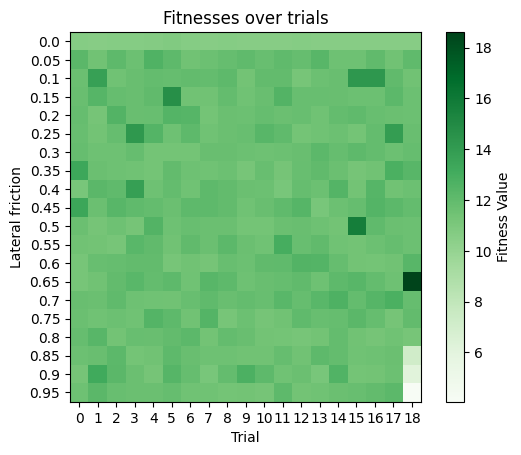

In [84]:
plt.imshow(fitnesses+10,cmap="Greens")
plt.title("Fitnesses over trials")
plt.ylabel("Lateral friction")
plt.xlabel("Trial")
plt.xticks([i for i in range(MAX)],[i for i in range(MAX)],rotation=0)
plt.yticks([i for i in range(len(np.arange(0,1,0.05)))],[np.round(i,2) for i in np.arange(0,1,0.05)],rotation=0)
cbar = plt.colorbar()
cbar.set_label("Fitness Value")
plt.show()

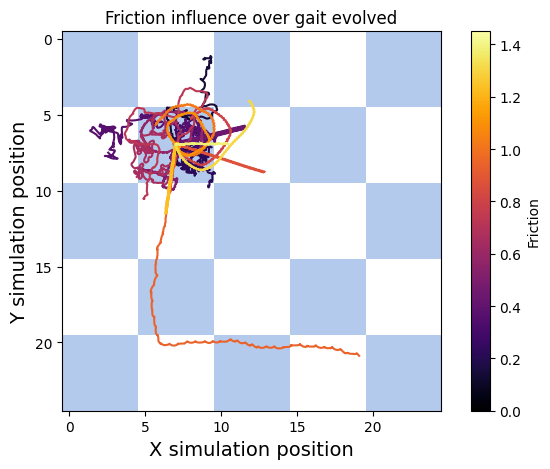

In [93]:
friction_data=[]
env=environment(0)
c=0
frictions=[]
labels=[]
for i,val in enumerate(np.arange(0,1,0.05)):
    best_of_trial=np.argmax(fitnesses[i])
    best=best_CPGs[i][best_of_trial]
    fit,hist,photos=env.runTrial(best,300,delay=0,fitness=F3)
    friction_data.append(copy.deepcopy(hist))
    frictions.append(hist['positions'])
    labels.append("Friction "+str(val))
env.stop()

shades = get_colormap_shades('inferno', len(np.arange(0,1,0.05)))
plot_trials(frictions,labels=labels,colours=shades,max_=-1,title="Friction influence over gait evolved",keys=np.arange(0,1.5,0.05),cmap=plt.cm.inferno)